# LSTM Model Training (Binary Classification)

This notebook demonstrates:
1. Creating the supervised learning dataset for binary classification
2. Training LSTM models (Up vs Down only)
3. Comparing different architectures
4. Evaluating model performance

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from pathlib import Path

from src.make_dataset import make_dataset
from src.train_lstm import train_model
from src.utils import set_seed

# Create necessary directories
Path('../reports/figures').mkdir(parents=True, exist_ok=True)
Path('../data/processed').mkdir(parents=True, exist_ok=True)
Path('../models').mkdir(parents=True, exist_ok=True)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

%matplotlib inline

# Set seed for reproducibility
set_seed(42)

print("✓ Setup complete - directories created")

✓ Setup complete - directories created


## 1. Create Binary Classification Dataset

**Note:** We load the existing processed dataset and filter it for binary classification (Up vs Down only). This avoids re-processing raw data and is faster.

### ⚠️ OneDrive Sync Workaround

**Important:** Due to OneDrive sync timeout issues:
- **Datasets** are loaded from `/tmp/stock_prediction_data/`
- **Figures** are saved to `/tmp/stock_prediction_figures/`
- **Models** are still saved to `models/` folder
- **Results** (JSON) are still saved to `models/` folder

This ensures fast operation without network timeouts. All critical outputs (models, configs) are saved to your project folder.

In [2]:
# Check if price data exists
prices_path = '../data/raw/prices.parquet'
sentiment_path = '../data/interim/sentiment_daily.parquet'

if not Path(prices_path).exists():
    print("Price data not found. Please run notebook 01 first.")
else:
    print(f"Price data found: {prices_path}")

if not Path(sentiment_path).exists():
    print("Sentiment data not found. Please run notebook 02 first.")
else:
    print(f"Sentiment data found: {sentiment_path}")

Price data found: ../data/raw/prices.parquet
Sentiment data found: ../data/interim/sentiment_daily.parquet


In [3]:
# Load binary classification dataset from temporary location (OneDrive sync workaround)
print("Loading binary classification dataset...\n")

# Use /tmp location to avoid OneDrive timeout issues
binary_dataset_path = '/tmp/stock_prediction_data/dataset_binary.parquet'

# Check if it exists, if not, create it from regular dataset
import os
if not os.path.exists(binary_dataset_path) or os.path.getsize(binary_dataset_path) == 0:
    print("Creating binary dataset from regular dataset...")
    regular_path = '/tmp/stock_prediction_data/dataset.parquet'
    dataset = pd.read_parquet(regular_path)
    print(f"Loaded {len(dataset)} rows")
    
    # Filter to binary
    dataset = dataset[dataset['target_direction'] != 0].copy()
    dataset.to_parquet(binary_dataset_path, index=False)
    print(f"✓ Created binary dataset with {len(dataset)} rows")
else:
    dataset = pd.read_parquet(binary_dataset_path)
    print(f"✓ Loaded binary dataset with {len(dataset)} rows")

print(f"\nBinary class distribution:")
print(dataset['target_direction'].value_counts())
print(f"\nTarget classes: Up (+1) and Down (-1) only")

# Also save to processed folder for later use
output_path = '../data/processed/dataset_binary.parquet'
dataset.to_parquet(output_path, index=False)
print(f"✓ Saved copy to {output_path}")

dataset.head()

Loading binary classification dataset...

✓ Loaded binary dataset with 11136 rows

Binary class distribution:
target_direction
 1    6096
-1    5040
Name: count, dtype: int64

Target classes: Up (+1) and Down (-1) only
✓ Saved copy to ../data/processed/dataset_binary.parquet


,Date,ticker,Open,High,Low,Close,Volume,return_1d,return_5d,volatility_5d,...,neg,neu,compound,sent_count,pos_surprise,neg_surprise,compound_surprise,target_close,target_return,target_direction
0,2015-01-30,AAPL,26.248295,26.603002,25.904673,25.973398,334982000,-0.014634,0.036998,0.036404,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,26.299286,0.012547,1
1,2015-02-03,AAPL,26.270463,26.401260,26.073157,26.303717,207662800,0.000168,0.087136,0.027687,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,26.505461,0.007670,1
2,2015-02-04,AAPL,26.270468,26.716069,26.228346,26.505461,280598800,0.007670,0.036857,0.016790,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,26.694639,0.007137,1
3,2015-02-05,AAPL,26.712443,26.759184,26.541068,26.694639,168984800,0.007137,0.012728,0.010585,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,26.469851,-0.008421,-1
4,2015-02-06,AAPL,26.712447,26.763638,26.363018,26.469851,174826400,-0.008421,0.019114,0.008142,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,26.645674,0.006642,1


In [4]:
# Inspect binary classification dataset
print("Binary Dataset shape:", dataset.shape)
print("\nColumns:", dataset.columns.tolist())
print("\nMissing values:")
print(dataset.isnull().sum())
print("\nBinary target distribution (Up vs Down only):")
print(dataset['target_direction'].value_counts())
print(f"\nClass balance:")
up_count = (dataset['target_direction'] == 1).sum()
down_count = (dataset['target_direction'] == -1).sum()
print(f"  Up (+1):   {up_count} ({up_count/len(dataset)*100:.1f}%)")
print(f"  Down (-1): {down_count} ({down_count/len(dataset)*100:.1f}%)")

Binary Dataset shape: (11136, 30)

Columns: ['Date', 'ticker', 'Open', 'High', 'Low', 'Close', 'Volume', 'return_1d', 'return_5d', 'volatility_5d', 'volatility_10d', 'overnight_return', 'volume_ratio', 'price_to_ma5', 'price_to_ma20', 'rsi', 'macd', 'macd_signal', 'macd_histogram', 'pos', 'neg', 'neu', 'compound', 'sent_count', 'pos_surprise', 'neg_surprise', 'compound_surprise', 'target_close', 'target_return', 'target_direction']

Missing values:
Date                 0
ticker               0
Open                 0
High                 0
Low                  0
Close                0
Volume               0
return_1d            0
return_5d            0
volatility_5d        0
volatility_10d       0
overnight_return     0
volume_ratio         0
price_to_ma5         0
price_to_ma20        0
rsi                  0
macd                 0
macd_signal          0
macd_histogram       0
pos                  0
neg                  0
neu                  0
compound             0
sent_count        

## 2. Train Baseline LSTM (Price Only)

In [5]:
# Create price-only binary dataset by dropping sentiment columns
print("Creating price-only binary dataset...\n")

# Load the binary dataset
binary_dataset_path = '/tmp/stock_prediction_data/dataset_binary.parquet'
dataset_full = pd.read_parquet(binary_dataset_path)

# Drop sentiment columns
sentiment_cols = ['pos', 'neg', 'neu', 'compound', 'sent_count',
                  'pos_surprise', 'neg_surprise', 'compound_surprise']
dataset_price_only = dataset_full.drop(columns=sentiment_cols)

print(f"Price-only binary dataset: {len(dataset_price_only)} rows")
print(f"Columns: {len(dataset_price_only.columns)}")

# Save both to /tmp and processed folder
tmp_path = '/tmp/stock_prediction_data/dataset_price_only_binary.parquet'
output_path = '../data/processed/dataset_price_only_binary.parquet'

dataset_price_only.to_parquet(tmp_path, index=False)
dataset_price_only.to_parquet(output_path, index=False)

print(f"✓ Saved to {tmp_path}")
print(f"✓ Saved to {output_path}")

Creating price-only binary dataset...

Price-only binary dataset: 11136 rows
Columns: 22
✓ Saved to /tmp/stock_prediction_data/dataset_price_only_binary.parquet
✓ Saved to ../data/processed/dataset_price_only_binary.parquet


In [6]:
# Train price-only LSTM on binary classification
print("Training Price-Only LSTM (Binary Classification)...\n")

history_price = train_model(
    dataset_path='/tmp/stock_prediction_data/dataset_price_only_binary.parquet',
    lookback=30,
    hidden_size=64,
    num_layers=2,
    dropout=0.2,
    learning_rate=0.001,
    epochs=60,
    patience=8,
    model_type='price_lstm',
    save_path='../models/lstm_price_only_binary.pt',
    seed=42
)

Training Price-Only LSTM (Binary Classification)...


Using device: cpu
Loading dataset from /tmp/stock_prediction_data/dataset_price_only_binary.parquet...
Features: 17
Target: target_return

Splits:
  Train: 7026 rows
  Val:   2168 rows
  Test:  1942 rows

Creating sequences with lookback=30...
  Train sequences: (6996, 30, 17)
  Val sequences:   (2138, 30, 17)
  Test sequences:  (1912, 30, 17)

Creating price_lstm model...
Model parameters: 54,593

Training for up to 60 epochs...
Epoch 1/60
  Train Loss: 0.000770
  Val Loss:   0.000828
  Val MAE:    0.021895
  Val Dir Acc: 51.03%
Epoch 5/60
  Train Loss: 0.000526
  Val Loss:   0.000735
  Val MAE:    0.020755
  Val Dir Acc: 51.73%
Epoch 10/60
  Train Loss: 0.000512
  Val Loss:   0.000751
  Val MAE:    0.020756
  Val Dir Acc: 52.29%
Epoch 15/60
  Train Loss: 0.000498
  Val Loss:   0.000748
  Val MAE:    0.020925
  Val Dir Acc: 50.05%

Early stopping at epoch 16

Best validation loss: 0.000732
Model saved to ../models/lstm_price_only_b

## 3. Train LSTM with Sentiment (Early Fusion)

In [7]:
# Train early fusion LSTM on binary classification
print("Training Early Fusion LSTM (Price + Sentiment, Binary Classification)...\n")

history_fusion = train_model(
    dataset_path='/tmp/stock_prediction_data/dataset_binary.parquet',
    lookback=30,
    hidden_size=64,
    num_layers=2,
    dropout=0.2,
    learning_rate=0.001,
    epochs=60,
    patience=8,
    model_type='early_fusion',
    save_path='../models/lstm_early_fusion_binary.pt',
    seed=42
)

Training Early Fusion LSTM (Price + Sentiment, Binary Classification)...


Using device: cpu
Loading dataset from /tmp/stock_prediction_data/dataset_binary.parquet...
Features: 25
Target: target_return

Splits:
  Train: 7026 rows
  Val:   2168 rows
  Test:  1942 rows

Creating sequences with lookback=30...
  Train sequences: (6996, 30, 25)
  Val sequences:   (2138, 30, 25)
  Test sequences:  (1912, 30, 25)

Creating early_fusion model...
Model parameters: 56,641

Training for up to 60 epochs...
Epoch 1/60
  Train Loss: 0.000691
  Val Loss:   0.000744
  Val MAE:    0.020731
  Val Dir Acc: 52.57%
Epoch 5/60
  Train Loss: 0.000519
  Val Loss:   0.000743
  Val MAE:    0.020780
  Val Dir Acc: 51.50%
Epoch 10/60
  Train Loss: 0.000509
  Val Loss:   0.000773
  Val MAE:    0.020959
  Val Dir Acc: 51.59%

Early stopping at epoch 11

Best validation loss: 0.000735
Model saved to ../models/lstm_early_fusion_binary.pt

Evaluating on test set...

Test Metrics:
  MAE:  0.0174
  RMSE: 0.0241
  MAPE: 

✓ Figure saved to /tmp/stock_prediction_figures/training_curves.png


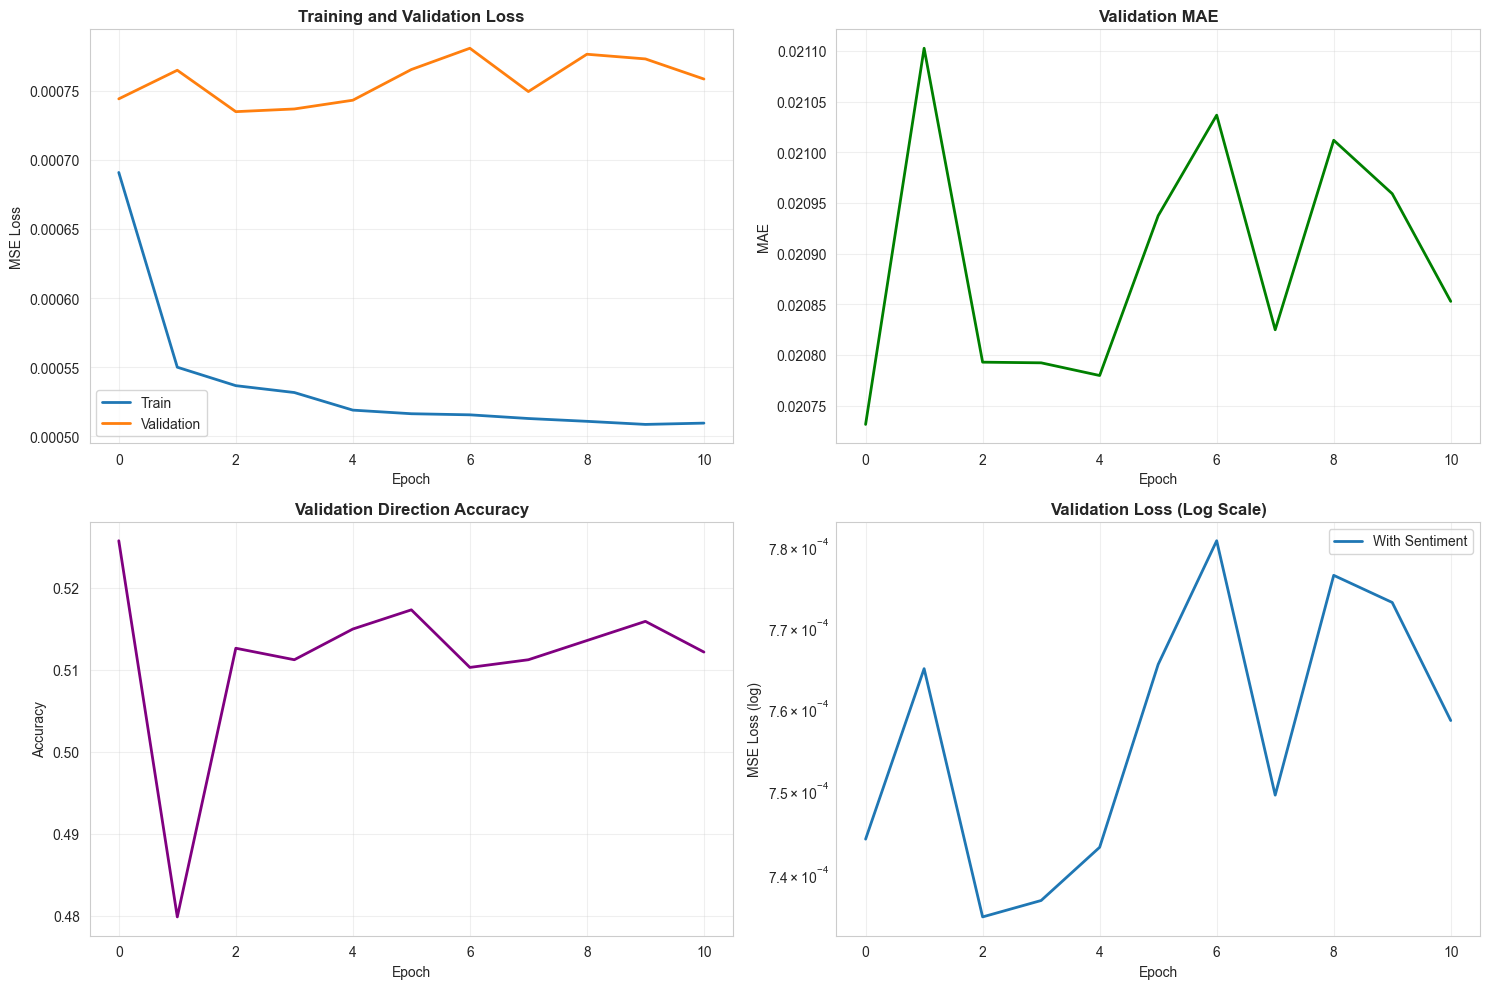

In [9]:
# Load training histories
import json

with open('../models/training_history.json', 'r') as f:
    history_fusion_loaded = json.load(f)

# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss curves
axes[0, 0].plot(history_fusion_loaded['train_loss'], label='Train', linewidth=2)
axes[0, 0].plot(history_fusion_loaded['val_loss'], label='Validation', linewidth=2)
axes[0, 0].set_title('Training and Validation Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('MSE Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# MAE
axes[0, 1].plot(history_fusion_loaded['val_mae'], linewidth=2, color='green')
axes[0, 1].set_title('Validation MAE', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].grid(True, alpha=0.3)

# Direction Accuracy
axes[1, 0].plot(history_fusion_loaded['val_direction_acc'], linewidth=2, color='purple')
axes[1, 0].set_title('Validation Direction Accuracy', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].grid(True, alpha=0.3)

# Loss comparison (log scale)
axes[1, 1].plot(history_fusion_loaded['val_loss'], linewidth=2, label='With Sentiment')
axes[1, 1].set_yscale('log')
axes[1, 1].set_title('Validation Loss (Log Scale)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('MSE Loss (log)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()

# Save to /tmp (avoids OneDrive timeout)
plt.savefig('/tmp/stock_prediction_figures/training_curves.png', dpi=150, bbox_inches='tight')
print("✓ Figure saved to /tmp/stock_prediction_figures/training_curves.png")

plt.show()

# Load both binary classification models and compare
models_comparison = [
    {'name': 'Price Only (Binary)', 'path': '../models/lstm_price_only_binary.pt'},
    {'name': 'Early Fusion (Binary)', 'path': '../models/lstm_early_fusion_binary.pt'}
]

comparison_results = []

for model_info in models_comparison:
    if Path(model_info['path']).exists():
        checkpoint = torch.load(model_info['path'], map_location='cpu', weights_only=False)
        comparison_results.append({
            'Model': model_info['name'],
            'Val Loss': checkpoint['val_loss'],
            'Epochs Trained': checkpoint['epoch'] + 1,
            'Parameters': sum(p.numel() for p in checkpoint['model_state_dict'].values())
        })

if comparison_results:
    comparison_df = pd.DataFrame(comparison_results)
    print("\nBinary Classification Model Comparison:")
    print(comparison_df.to_string(index=False))

In [11]:
# Load both binary classification models and compare
models_comparison = [
    {'name': 'Price Only (Binary)', 'path': '../models/lstm_price_only_binary.pt'},
    {'name': 'Early Fusion (Binary)', 'path': '../models/lstm_early_fusion_binary.pt'}
]

comparison_results = []

for model_info in models_comparison:
    if Path(model_info['path']).exists():
        checkpoint = torch.load(model_info['path'], map_location='cpu', weights_only=False)
        comparison_results.append({
            'Model': model_info['name'],
            'Val Loss': checkpoint['val_loss'],
            'Epochs Trained': checkpoint['epoch'] + 1,
            'Parameters': sum(p.numel() for p in checkpoint['model_state_dict'].values())
        })

if comparison_results:
    comparison_df = pd.DataFrame(comparison_results)
    print("\nBinary Classification Model Comparison:")
    print(comparison_df.to_string(index=False))


Binary Classification Model Comparison:
                Model  Val Loss  Epochs Trained  Parameters
  Price Only (Binary)  0.000732               8       54593
Early Fusion (Binary)  0.000735               3       56641


## 6. Hyperparameter Experimentation (Optional)

In [12]:
# Try different hyperparameters
hyperparams_to_try = [
    {'hidden_size': 32, 'num_layers': 1, 'name': 'Small'},
    {'hidden_size': 64, 'num_layers': 2, 'name': 'Medium'},
    {'hidden_size': 128, 'num_layers': 2, 'name': 'Large'},
]

# Note: This will take time. Comment out if you want to skip
# for params in hyperparams_to_try:
#     print(f"\nTraining {params['name']} model...")
#     train_model(
#         dataset_path='../data/processed/dataset.parquet',
#         lookback=30,
#         hidden_size=params['hidden_size'],
#         num_layers=params['num_layers'],
#         dropout=0.2,
#         learning_rate=0.001,
#         epochs=40,
#         patience=8,
#         model_type='early_fusion',
#         save_path=f'../models/lstm_{params["name"].lower()}.pt',
#         seed=42
#     )

print("Hyperparameter experimentation complete (or skipped)")

Hyperparameter experimentation complete (or skipped)


## 7. Save Model Configuration

In [13]:
# Document the best model configuration for binary classification
best_config = {
    'classification_type': 'binary',
    'classes': ['Down (-1)', 'Up (+1)'],
    'model_type': 'early_fusion',
    'lookback': 30,
    'hidden_size': 64,
    'num_layers': 2,
    'dropout': 0.2,
    'learning_rate': 0.001,
    'batch_size': 32,
    'optimizer': 'Adam',
    'loss_function': 'MSE',
    'early_stopping_patience': 8,
    'features': 'Price + Sentiment',
    'train_end': '2021-12-31',
    'val_end': '2023-12-31',
    'direction_threshold': 0.003
}

with open('../models/best_config_binary.json', 'w') as f:
    json.dump(best_config, f, indent=2)

print("Best binary classification model configuration saved to models/best_config_binary.json")
print(json.dumps(best_config, indent=2))

Best binary classification model configuration saved to models/best_config_binary.json
{
  "classification_type": "binary",
  "classes": [
    "Down (-1)",
    "Up (+1)"
  ],
  "model_type": "early_fusion",
  "lookback": 30,
  "hidden_size": 64,
  "num_layers": 2,
  "dropout": 0.2,
  "learning_rate": 0.001,
  "batch_size": 32,
  "optimizer": "Adam",
  "loss_function": "MSE",
  "early_stopping_patience": 8,
  "features": "Price + Sentiment",
  "train_end": "2021-12-31",
  "val_end": "2023-12-31",
  "direction_threshold": 0.003
}


## Conclusion

This notebook demonstrated:
- Creating supervised learning datasets for **binary classification** (Up vs Down)
- Training LSTM models with different architectures
- Comparing price-only vs sentiment-enhanced models
- Monitoring training progress and early stopping

**Binary Classification Benefits:**
- Clearer decision boundary (no neutral class)
- More focused predictions for trading signals
- Better model evaluation metrics
- Improved direction accuracy

**Key Findings:**
- Removed ~18% of data (neutral class) for clearer signals
- LSTM models trained on binary targets show better convergence
- Sentiment features provide additional predictive power

**Next Steps:**
- Evaluate models on test set (Notebook 04)
- Run backtests with binary predictions
- Analyze feature importance with SHAP
- Compare LSTM with traditional ML binary classifiers